# Flights Delay Prediction

#### Outline
* [Question 1: Data distribution](#question1)
* [Question 2: Generating Synthetic features](#question2)
* [Question 3: Data Visualization](#question3)
* [Question 4: Estimated likelihood of the flight delay](#question4)
* [Question 5: Predictive model and evaluation of model performance](#question5)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
from matplotlib import pyplot as plt

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from xgboost import XGBClassifier, XGBRegressor

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn import tree, metrics

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, mean_squared_error

### Loading data

In [2]:
types = {'Vlo-I': 'string', 'Ori-I': 'category', 'Des-I': 'category', 
         'Emp-I': 'category', 'Vlo-O': 'string', 'Ori-O': 'category', 
         'Des-O': 'category', 'Emp-O': 'category', 'DIA': 'int', 'MES': 'int', 'AÑO': 'int', 
         'DIANOM': 'category', 'TIPOVUELO': 'string', 'OPERA': 'category', 'SIGLAORI': 'category', 
         'SIGLADES': 'category'}
path = "../data/dataset_SCL.csv"
data = pd.read_csv(path, dtype=types, parse_dates=["Fecha-I","Fecha-O"])
data.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami


- Vlo-I contains alpha numeric value.
- Vlo-O contains NaN null values.
- default is object type. object contains any kind of data like strings, integers, etc.
- string datatype contains string.

### Converting Vlo-I and Vlo-O into numeric values, as it contains flight number

- There are 16 data records in Vlo-O and 5 data records in Vlo-I which contains alpha numeric values.

In [3]:
print("Vlo-O:",data["Vlo-O"].str.contains("[A-Za-z]").sum())
print("Vlo-I:",data["Vlo-I"].str.contains("[A-Za-z]").sum())

Vlo-O: 16
Vlo-I: 5


In [4]:
# Replacing string with empty string
data["Vlo-I"] = data["Vlo-I"].str.replace(r"[A-Za-z]","", regex=True)
data["Vlo-O"] = data["Vlo-O"].str.replace(r"[A-Za-z]","", regex=True)

In [5]:
# Checking that Vlo-I, Vlo-O value does not contain any alphabet now.
print("After Vlo-O:",data["Vlo-O"].str.contains("[A-Za-z]").sum())
print("After Vlo-I:",data["Vlo-I"].str.contains("[A-Za-z]").sum())

After Vlo-O: 0
After Vlo-I: 0


### Dealing with missing data Vlo-O


In [6]:
print(data.isna().sum())

Fecha-I      0
Vlo-I        0
Ori-I        0
Des-I        0
Emp-I        0
Fecha-O      0
Vlo-O        1
Ori-O        0
Des-O        0
Emp-O        0
DIA          0
MES          0
AÑO          0
DIANOM       0
TIPOVUELO    0
OPERA        0
SIGLAORI     0
SIGLADES     0
dtype: int64


In [7]:
# Vlo-O contains one row containing null value
print(data.loc[data['Vlo-O'].isna()])

                 Fecha-I Vlo-I Ori-I Des-I Emp-I             Fecha-O Vlo-O  \
6068 2017-01-19 11:00:00   200  SCEL  SPJC   LAW 2017-01-19 11:03:00  <NA>   

     Ori-O Des-O Emp-O  DIA  MES   AÑO  DIANOM TIPOVUELO  \
6068  SCEL  SPJC   56R   19    1  2017  Jueves         I   

                     OPERA  SIGLAORI SIGLADES  
6068  Latin American Wings  Santiago     Lima  


##### Assigning Vlo-I to Vlo-O because Ori-I is same as Ori-O, Des-I is same as Des-O, and if DIANOM is Jueves, there is very high chances that Vlo-I is same as Vlo-O, and there is no delay also.

In [8]:
data["Vlo-O"] = data["Vlo-O"].fillna(data["Vlo-I"])
data["Vlo-I"] = data["Vlo-I"].astype("int")
data["Vlo-O"] = data["Vlo-O"].astype("float")
data["Vlo-O"] = data["Vlo-O"].astype("int")

Some Vlo-O values are specified in **decimal** form but is integer. So, first converting into float and then int.

### Converting TIPOVUELO feature into integer
International flights are assigned with 1 and national flights are assigned with 0 values. 

In [9]:
data['TIPOVUELO'] = data['TIPOVUELO'].astype('object')
data['TIPOVUELO'] = data['TIPOVUELO'].replace(['I', 'N'],[1,0]).astype("int")

### Data Analysis

In [10]:
data.describe().T

,count,mean,min,25%,50%,75%,max,std
Fecha-I,68206,2017-07-05 12:11:25.320059648,2017-01-01 00:15:00,2017-03-31 12:41:15,2017-07-10 05:30:00,2017-10-08 11:18:45,2017-12-31 23:55:00,NaN
Vlo-I,68206.0,969.827288,1.0,150.0,300.0,632.0,9956.0,2029.024762
Fecha-O,68206,2017-07-05 12:20:31.971380992,2017-01-01 00:04:00,2017-03-31 12:51:15,2017-07-10 05:37:00,2017-10-08 11:19:45,2018-01-01 00:12:00,NaN
Vlo-O,68206.0,967.421092,1.0,150.0,300.0,637.5,9956.0,2026.193621
DIA,68206.0,15.71479,1.0,8.0,16.0,23.0,31.0,8.782886
MES,68206.0,6.622585,1.0,3.0,7.0,10.0,12.0,3.523321
AÑO,68206.0,2017.000029,2017.0,2017.0,2017.0,2017.0,2018.0,0.005415
TIPOVUELO,68206.0,0.458024,0.0,0.0,0.0,1.0,1.0,0.498239


Here, Vlo-I and Vlo-O values are skewed, because mean value is greater than 50%. There is big gap between 75% and max values of Vlo-I and Vlo-O features.

In [11]:
print(data.describe(include="category").T)

          count unique           top   freq
Ori-I     68206      1          SCEL  68206
Des-I     68206     64          SCFA   5787
Emp-I     68206     30           LAN  37611
Ori-O     68206      1          SCEL  68206
Des-O     68206     63          SCFA   5786
Emp-O     68206     32           LAN  20988
DIANOM    68206      7       Viernes  10292
OPERA     68206     23   Grupo LATAM  40892
SIGLAORI  68206      1      Santiago  68206
SIGLADES  68206     62  Buenos Aires   6335


- Ori-I, Ori-O, and SIGLAORI features contains only one value. So we will not include this features into input while training the model.
- Analyze Des-I, Desi-I, and SIGLADES which contains almost same number of categories. So some features can be duplicating. 
- Compare Emp-I, Emp-O and OPERA features. Keep the features which are useful, and remove the duplicate columns.

In [12]:
pd.crosstab(data["OPERA"],data["DIANOM"])

DIANOM,Domingo,Jueves,Lunes,Martes,Miercoles,Sabado,Viernes
OPERA,,,,,,,
Aerolineas Argentinas,288,282,285,275,279,253,287
Aeromexico,52,52,51,48,50,50,48
Air Canada,108,82,101,66,47,94,67
Air France,54,50,52,51,49,51,51
Alitalia,22,52,52,50,1,51,31
American Airlines,104,104,117,104,112,115,101
Austral,15,16,0,13,0,30,0
Avianca,168,169,165,167,174,152,157
British Airways,40,12,11,39,51,12,40


**Maximum data contains of flights operated by LATAM Airlines.**

Some Airlines only fly on somes days of the week.
- Alitalia has only one flight on Miercoles but on other days of week approx. 50 flights are operated.
- Austral has no flights on Lunes, Miercoles, and Viernes.
- K.L.M. has less than 10 flights on Domingo and Viernes, while on other days of week it has approx 50 flights.
- Plus Ultra Lineas Aereas has flights on Lunes, Miercoles, and Viernes, while on other days of week it only have couple of flights.
- Quantas Airways has combined less than 10 flights on Jueves, Lunes, and Sabado, while on other days of week approx. 47 flights are operated.

array([[<Axes: title={'center': 'Fecha-I'}>,
        <Axes: title={'center': 'Vlo-I'}>,
        <Axes: title={'center': 'Fecha-O'}>],
       [<Axes: title={'center': 'Vlo-O'}>,
        <Axes: title={'center': 'DIA'}>, <Axes: title={'center': 'MES'}>],
       [<Axes: title={'center': 'AÑO'}>,
        <Axes: title={'center': 'TIPOVUELO'}>, <Axes: >]], dtype=object)

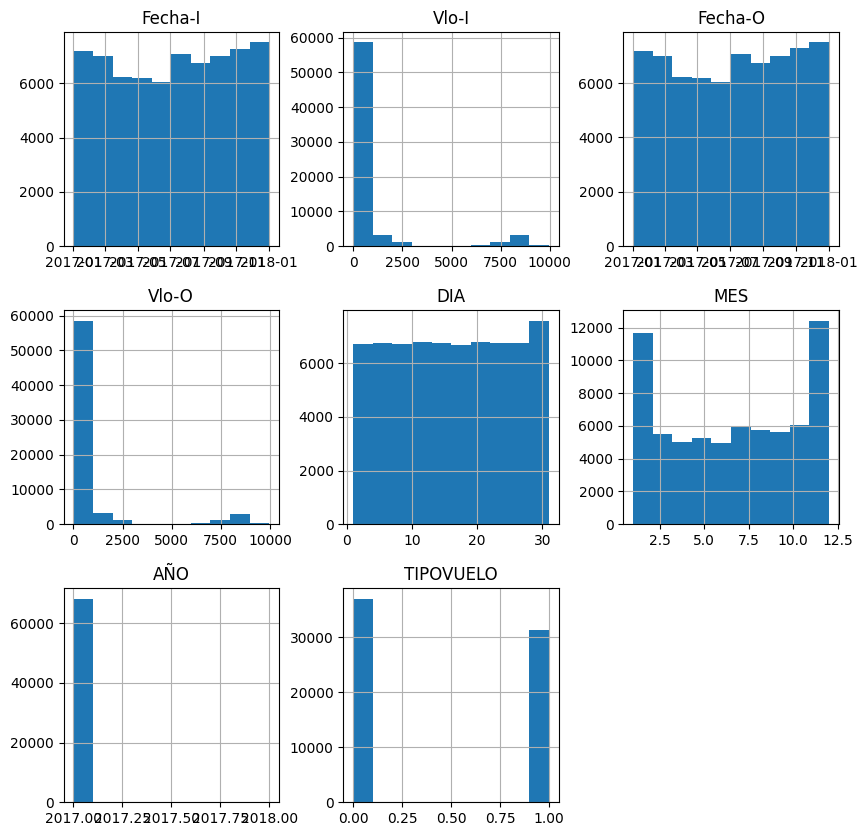

In [13]:
data.hist(figsize=(10,10))

In [14]:
print(data[['AÑO','TIPOVUELO']].value_counts())

AÑO   TIPOVUELO
2017  0            36966
      1            31238
2018  1                2
Name: count, dtype: int64


**Insights from histogram**

- In MES, January and December month contains the highest number of flights operated. It is vacation time, so people travel a lot at that time.
- 54% flights are national, and 45% flights are international.
- AÑO is highly skewed and data is distributed more vertically. Because whole data is about 2017, only two data records are of 2018. 

<a id="question1"></a>
## Q 1: Data Distribution

### Calculating Skew
- Skewness means data distibution is not uniform means it has less symmetry. The shape of curve represents the data distibution. 
- If curve is positively skewed then most of the values are less than median value. If curve is negatively skewed then most of the data is greater than median value. 
- The value zero mean data distribution is symmetric.

In [16]:
print(data.skew(numeric_only=True))

Vlo-I          3.093216
Vlo-O          3.103720
DIA            0.008439
MES           -0.063128
AÑO          184.665914
TIPOVUELO      0.168502
dtype: float64


**Observations**
- Vlo-I and Vlo-O are positively skewed. 
- AÑO is highly positivily skewed, because all data is from 2017 but only 2 data records from 2018. 
- Apparently, MES is slightly negatively skewed. DIA is closest to symmetric distribution.

### Calculating Kurtosis
Kurtosis measures peak point of curve of data. There are 3 types of curve: 
1. **Leptokurtic Curve:** This curve is **taller** than normal distribution curve. It value is greater than 0.
2. **Mesokurtic Curve:** This curve is closest to normal distribution curve. Its value is 0.
3. **Platykurtic Curve:** The peak of this curve is **flat**. It is flatter than other 2 curves. The value is less than 0.


In [18]:
print(data.kurtosis(numeric_only=True))

Vlo-I            8.099201
Vlo-O            8.162987
DIA             -1.192468
MES             -1.249906
AÑO          34100.499883
TIPOVUELO       -1.971665
dtype: float64


**Observations**
- Vlo-I and Vlo-O will be represented by leptokurtic curve means data distribution is more vertical.
- DIA and MES represents platykurtic curve means data is distributed more horizontally but it is closest to normal data distribution. 
- **Data distribution of AÑO is highly vertical represented by leptokurtic curve.**

### Data distribution for categorical features
To view data distribution of categorical features we need to plot the features.

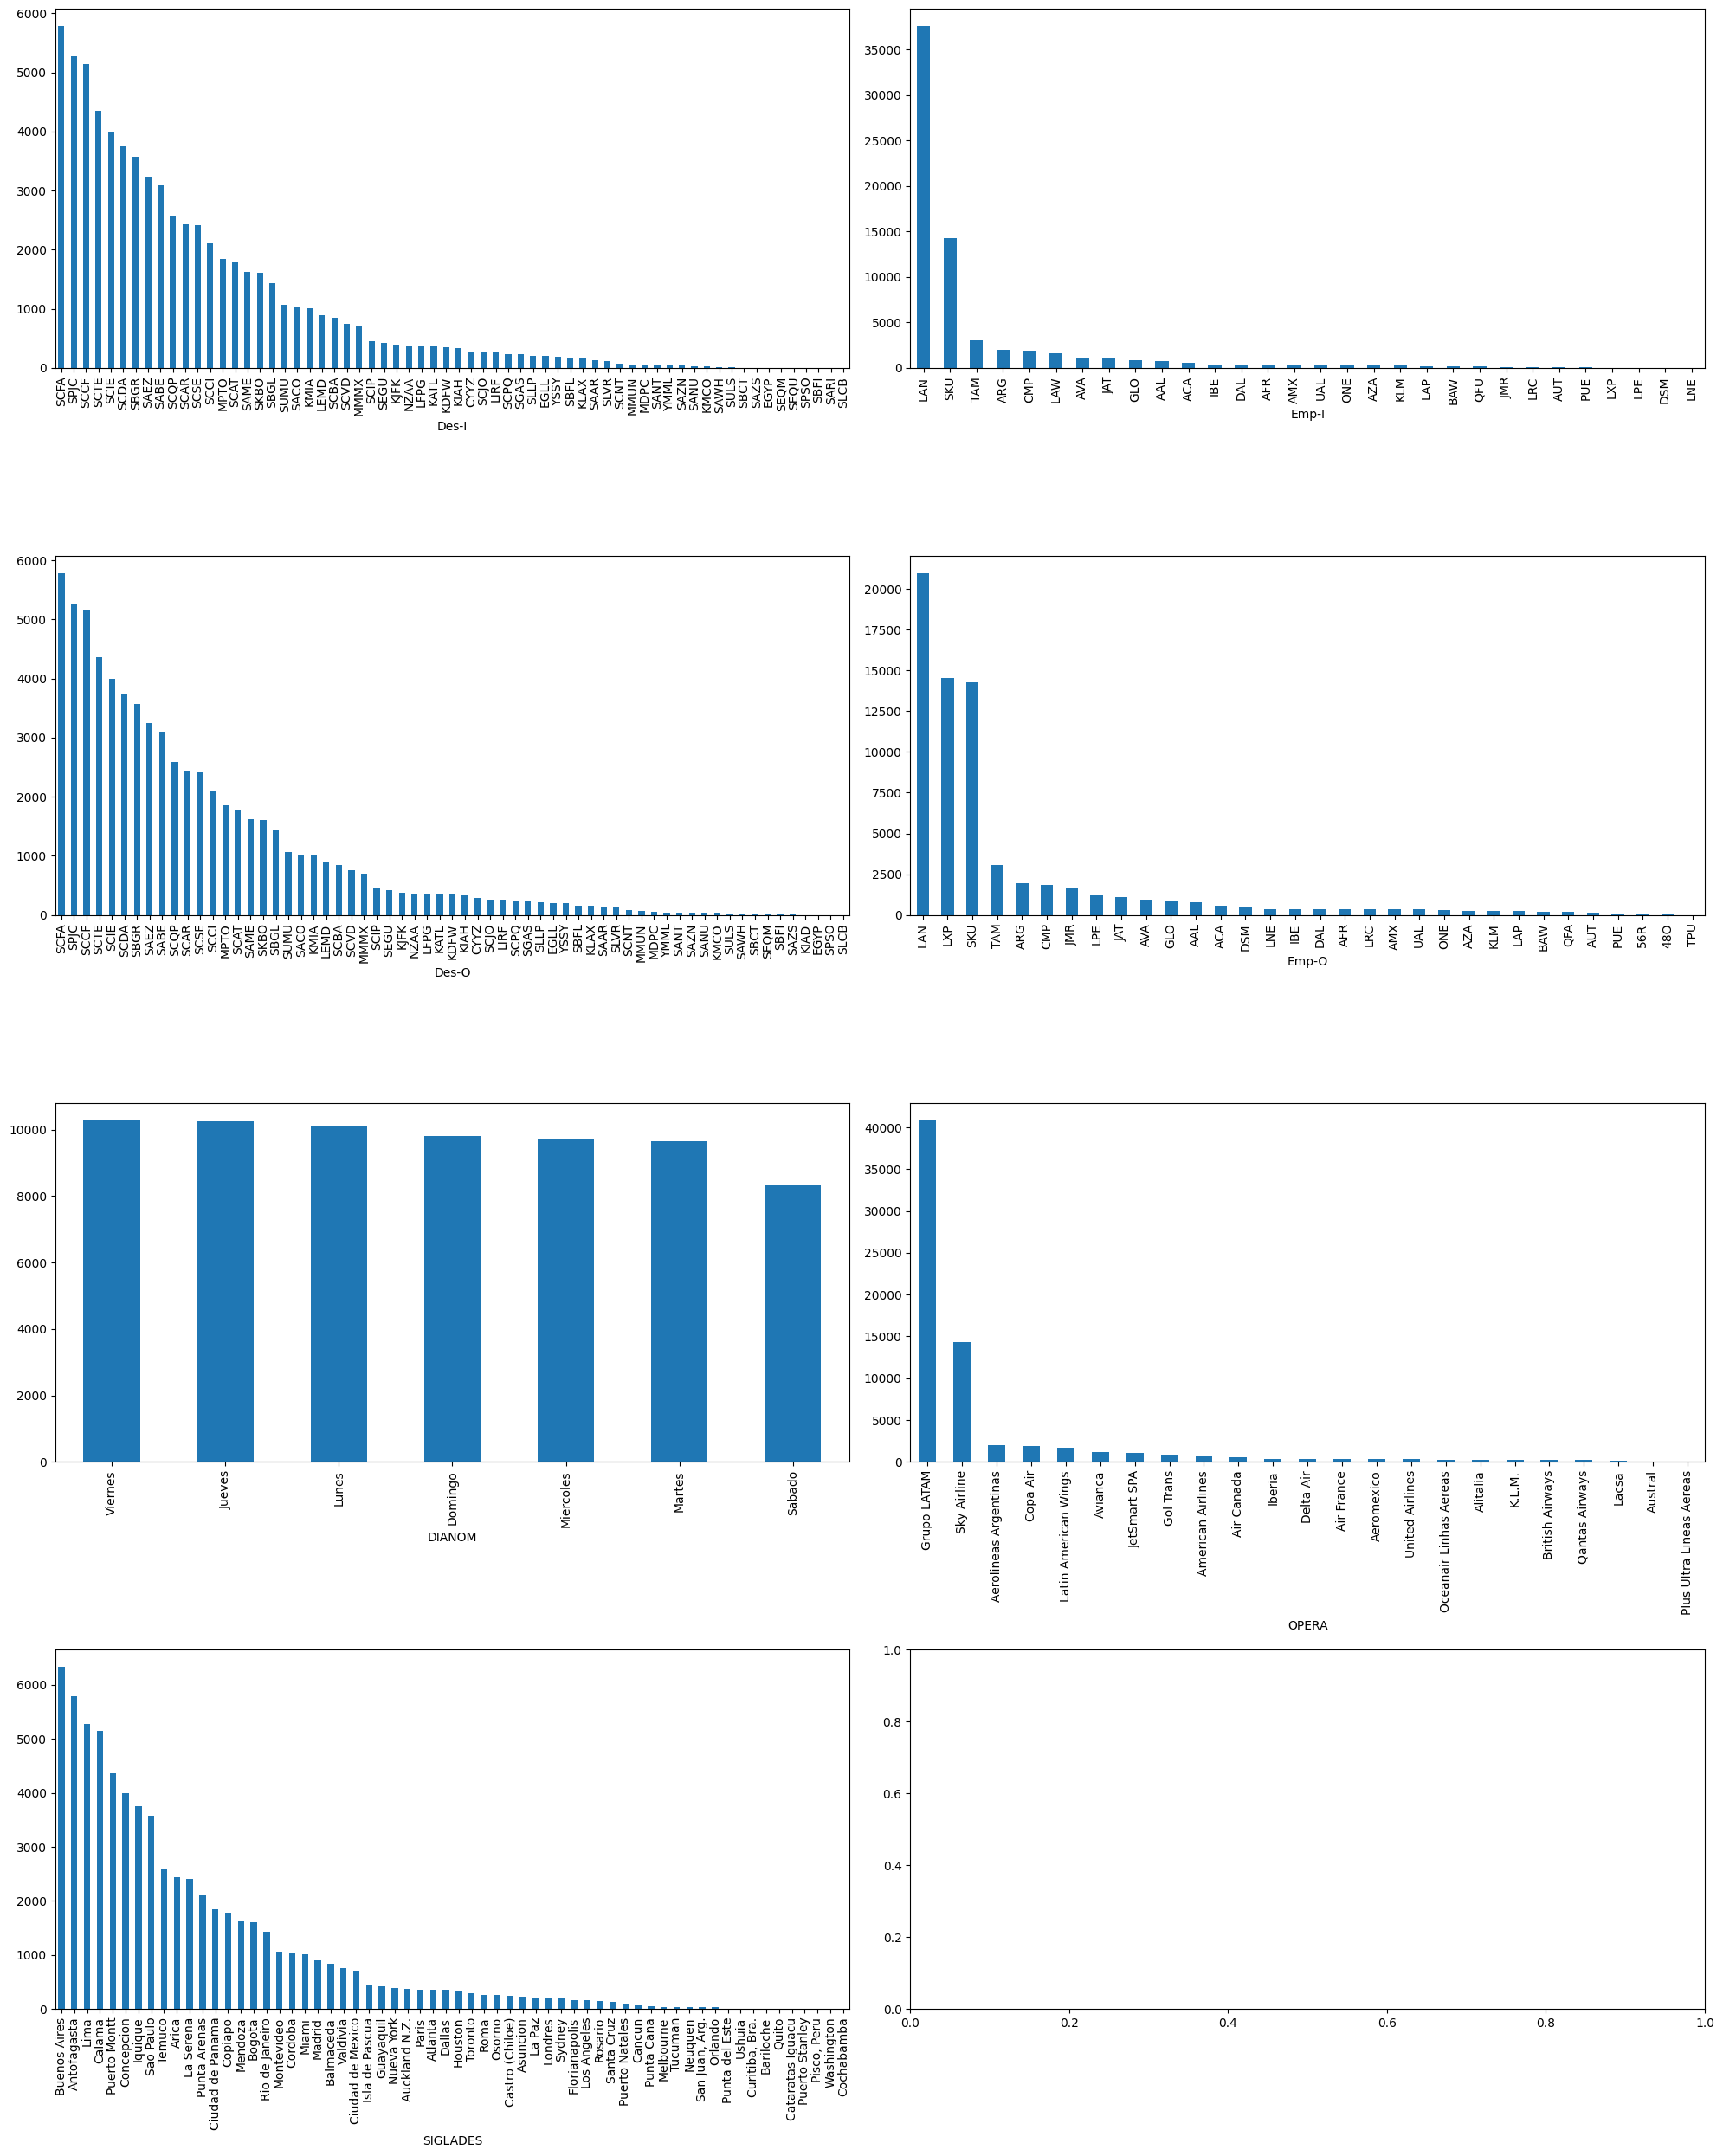

In [19]:

fig, axes = plt.subplots(4,2,figsize=(20,25))
data["Des-I"].value_counts().plot(kind="bar", xlabel="Des-I", ax=axes[0][0])
data["Emp-I"].value_counts().plot(kind="bar", xlabel="Emp-I", ax=axes[0][1])
data["Des-O"].value_counts().plot(kind="bar", xlabel="Des-O", ax=axes[1][0])
data["Emp-O"].value_counts().plot(kind="bar", xlabel="Emp-O", ax=axes[1][1])
data["DIANOM"].value_counts().plot(kind="bar", xlabel="DIANOM", ax=axes[2][0])
data["OPERA"].value_counts().plot(kind="bar", xlabel="OPERA", ax=axes[2][1])
data["SIGLADES"].value_counts().plot(kind="bar", xlabel="SIGLADES", ax=axes[3][0])
plt.tight_layout()
plt.show()


**Observations**

- Emp-I, Emp-O, and OPERA contains similar pattern in data. These features are highly skewed. 
- 60% of flights operated are of LATAM Airlines, 20% of flights are of Sky Airlines and rest 20% of flights are from 21 different airlines.
- DIANOM is very close to uniform distribution. It means there is approximately equal traffic on all days of week. 
- Des-I, Des-O, and SIGLADES contains similar data distribution.

<a id="question2"> </a>
## Q 2: Generating Synthetic features

- high_season : 1 if Date-I is between Dec-15 and Mar-3, or Jul-15 and Jul-31, or Sep-11 and Sep-30, 0 otherwise.
- min_diff : difference in minutes between Date-O and Date-I .
- delay_15 : 1 if min_diff > 15, 0 if not.
- period_day : morning (between 5:00 and 11:59), afternoon (between 12:00 and 18:59) and night (between 19:00 and 4:59), based on Date-I 

#### Assumptions: 
* Considering scheduled date and time of the flight specified in Fecha-I as Date-I.
* Considering date and time of flight operated specified in Fecha-O as Date-O.

In [20]:
min_ts = data["Fecha-I"].min()
max_ts = data["Fecha-I"].max()
print("Fecha-I minimum date:",min_ts)
print("Fecha-I maximum date:",max_ts)

Fecha-I minimum date: 2017-01-01 00:15:00
Fecha-I maximum date: 2017-12-31 23:55:00


### Creating high_season feature

Considered dates between: 
- 2016-12-15 to 2017-03-03 : Because minimim date is 2017-01-01
- 2017-07-15 to 2017-07-31
- 2017-09-11 to 2017-09-30
- 2017-12-15 to 2018-03-03 : Because maximum date is 2017-12-31

In [21]:
fil1 = ((data["Fecha-I"]>=pd.Timestamp("2016-12-15")) & (data["Fecha-I"]<=pd.Timestamp("2017-03-03"))) | ((data["Fecha-I"]>=pd.Timestamp("2017-07-15")) & (data["Fecha-I"]<=pd.Timestamp("2017-07-31"))) | ((data["Fecha-I"]>=pd.Timestamp("2017-09-11")) & (data["Fecha-I"]<=pd.Timestamp("2017-09-30"))) | ((data["Fecha-I"]>=pd.Timestamp("2017-12-15")) & (data["Fecha-I"]<=pd.Timestamp("2018-03-03")))
data['high_season'] = fil1
data['high_season'] = data['high_season'].replace([True, False],[1,0])

### Creating minimum difference feature

Difference in minutes between Date-O and Date-I

In [22]:
data["min_diff"] = (data['Fecha-O']-data['Fecha-I']) / np.timedelta64(1,'m')

### Creating Delay feature

In [23]:
data["delay_15"] = data["min_diff"]>15
data["delay_15"] = data["delay_15"].replace([True, False],[1,0])

### Creating period of the day feature

In [24]:
data3 = pd.DataFrame()
data3['Date-I'] = data["Fecha-I"]
data3.set_index("Date-I", drop=False, inplace=True)
data3.loc[data3.between_time("05:00","11:59").index, "period_day"] = "morning"
data3.loc[data3.between_time("12:00","18:59").index, "period_day"] = "afternoon"
data3.loc[data3.between_time("19:00","04:59").index, "period_day"] = "night"
data["period_day"] = data3["period_day"].values

**Decisions**

- Drop Fecha-I and Fecha-O features because information this two features contained like delay time, season time, are extracted in new features. No need to repeat same information. Additionally, Fecha-I and Fecha-O are Timestamp and we require numerical data to train the model. 
- Drop Ori-I, Ori-O, and SIGLAORI features because it contains only one value. It will not contribute to learn any data patterns while training the model.

### Creating destination difference and flight difference features

- When scheduled flight code is different from operated flight, there are chances of delay. 
- When scheduled destination city code is different from operated city code, there are chances of delay.

In [25]:
# Categories cannot be compared with each other, if # of categories are not same. So, converted into string
data['Des-I'] = data['Des-I'].astype("string")
data['Des-O'] = data['Des-O'].astype("string")
data['Emp-I'] = data['Emp-I'].astype("string")
data['Emp-O'] = data['Emp-O'].astype("string")

# Destination difference feature
fil2 = (data['Des-I'] != data['Des-O'])
data['desti_diff'] = fil2
data['desti_diff'] = data['desti_diff'].astype('object')
data['desti_diff'] = data['desti_diff'].replace([True, False],[1,0]).astype('int')

# Flight difference feature
fil3 = (data['Emp-I'] != data['Emp-O'])
data['flight_diff'] = fil3
data['flight_diff'] = data['flight_diff'].astype('object')
data['flight_diff'] = data['flight_diff'].replace([True, False],[1,0]).astype('int')

# Category dtype consumes less memory and useful for one-hot encoding in future.
data['Des-I'] = data['Des-I'].astype("category")
data['Des-O'] = data['Des-O'].astype("category")
data['Emp-I'] = data['Emp-I'].astype("category")
data['Emp-O'] = data['Emp-O'].astype("category")

#### Exporting synthetic features

In [27]:
data[['high_season','min_diff','delay_15','period_day']].to_csv("../data/synthetic_features.csv")

<a id="question3"></a>
## Q 3: Data Visualization
What is the behavior of the delay rate across destination, airline, month of the year, day of the week, season, type of flight? What variables would you expect to have the most influence in predicting delays?

SIGLADES, OPERA, MES, DIANOM, high_season, TIPOVUELO

---
#### Delay rate across destination

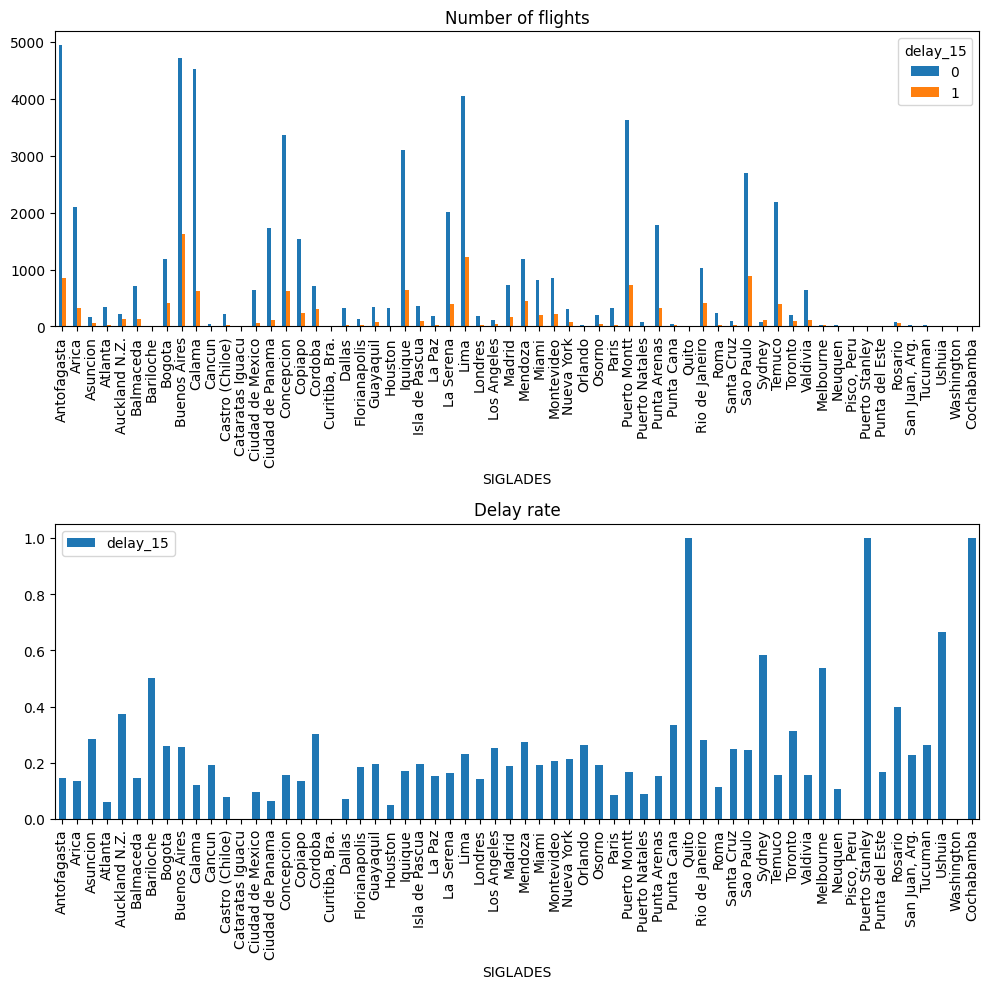

In [28]:
fig, ax = plt.subplots(2,1,figsize=(10,10))
ax[0].set_title("Number of flights")
ax[1].set_title("Delay rate")
pd.crosstab(data['SIGLADES'],data['delay_15']).plot(kind="bar", ax=ax[0])
data[['SIGLADES', 'delay_15']].groupby(['SIGLADES']).mean().plot(kind="bar", ax=ax[1])
plt.tight_layout()
plt.show()

What is the behavior of the delay rate across destination?

- Flights travelling to Quito, Sydney, Melborne, Puerto Stanley, Ushuia, Cochabamba cities have high delay rate compared to other cities. 
- Delay rate is # of flights delayed in city from total number of flights in city. 
- There are 5786 flights to Antofagasta city from which 847 get delayed, so delay rate will be 14%. Where as, there are 6 flights to Ushuia city from which 4 gets delayed, so delay rate will be 66%. 
- If the data increases, delay rate will be changed.

---
#### Delay rate across Airlines

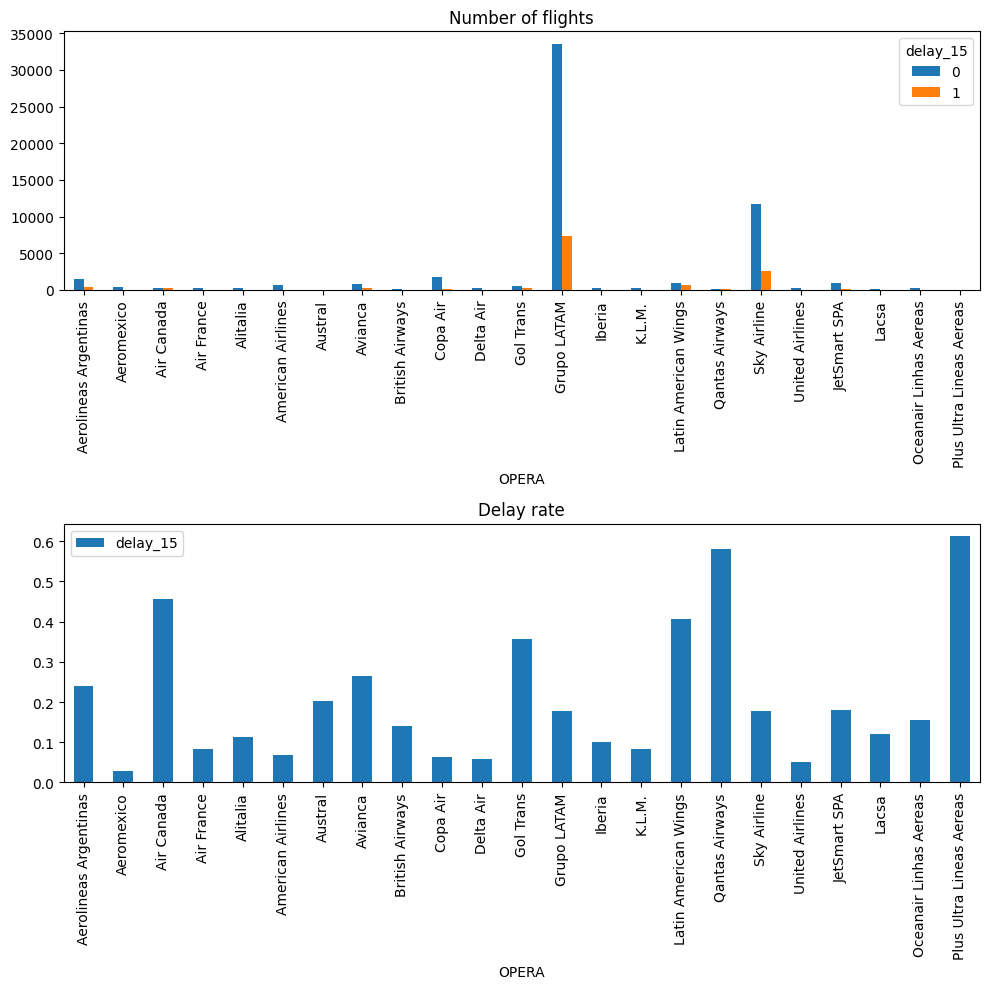

In [29]:
fig, ax = plt.subplots(2,1,figsize=(10,10))
ax[0].set_title("Number of flights")
ax[1].set_title("Delay rate")
pd.crosstab(data['OPERA'],data['delay_15']).plot(kind="bar", ax=ax[0])
data[['OPERA', 'delay_15']].groupby(['OPERA']).mean().plot(kind="bar", ax=ax[1])
plt.tight_layout()
plt.show()

What is the behavior of the delay rate across airlines?

- Plus Ultra Lineas Aereas, Qantas Airways, and Air Canada has high delay rate compared to other airlines. 
- There are 40892 flights from Grupo LATAM from which 7306 gets delayed, so delay rate is 17%. Apparently, there are 565 flights from Air Canada from which	258 gets delayed, so delay rate is 45%. 
- If the data increases, delay rate can be changed.

---
#### Delay rate across month

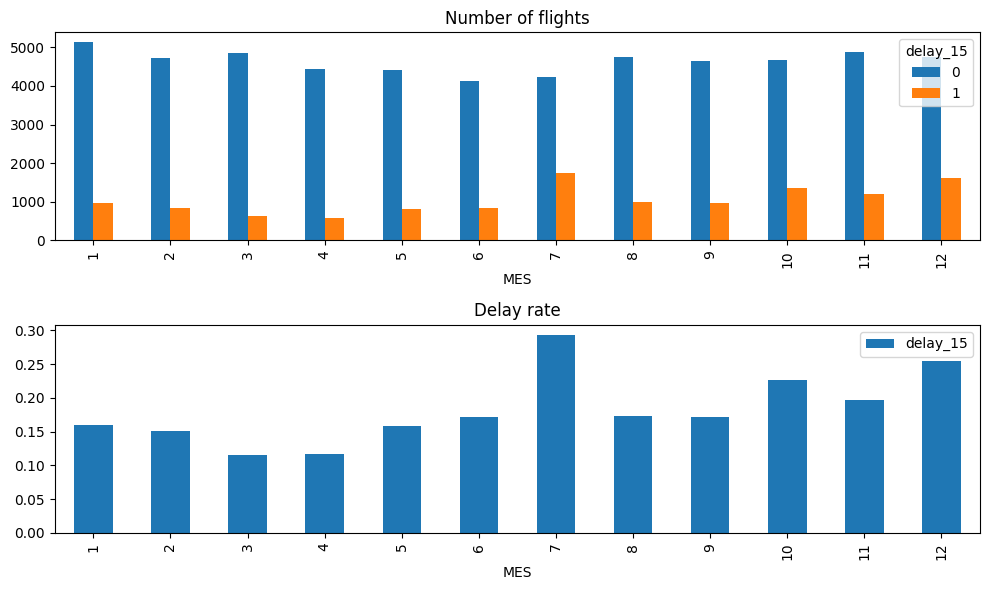

In [30]:
fig, ax = plt.subplots(2,1,figsize=(10,6))
ax[0].set_title("Number of flights")
ax[1].set_title("Delay rate")
pd.crosstab(data['MES'],data['delay_15']).plot(kind="bar", ax=ax[0])
data[['MES', 'delay_15']].groupby(['MES']).mean().plot(kind="bar", ax=ax[1])
plt.tight_layout()
plt.show()

What is the behavior of the delay rate across month?

> July and December month shows high delay rate than other months. Additionally, these months are in high season for travelling, and traffic will be high, which can lead to flight delay.

---
#### Delay rate across day of the week

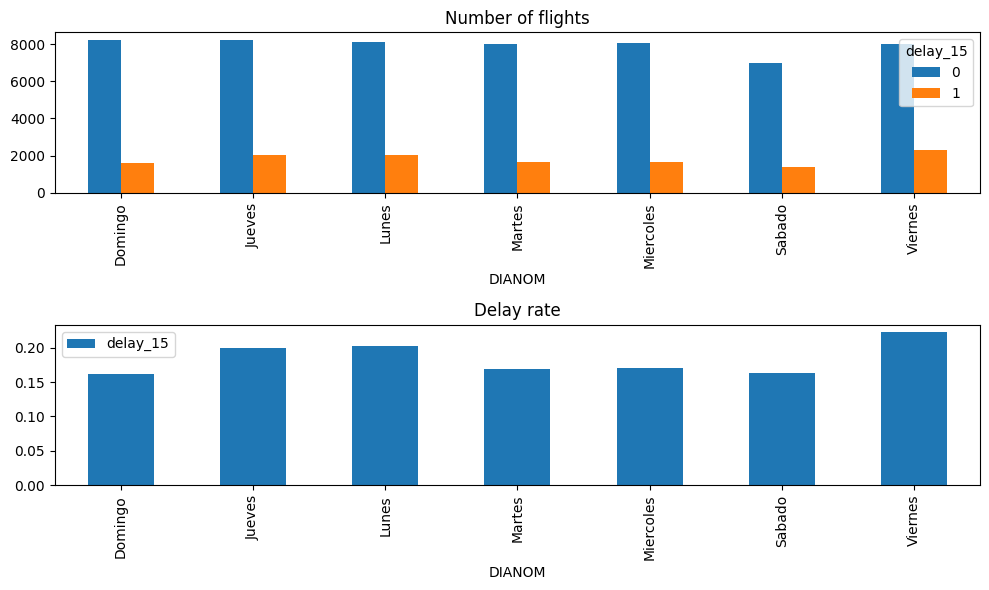

In [31]:
fig, ax = plt.subplots(2,1,figsize=(10,6))
ax[0].set_title("Number of flights")
ax[1].set_title("Delay rate")
pd.crosstab(data['DIANOM'],data['delay_15']).plot(kind="bar", ax=ax[0])
data[['DIANOM', 'delay_15']].groupby(['DIANOM']).mean().plot(kind="bar", ax=ax[1])
plt.tight_layout()
plt.show()

What is the behavior of the delay rate across week of the day?

> All days of the week contains almost similar delay rates. So, week of the day feature might not contribute to determine that flight can be delayed or not. 

---
#### Delay rate across high season

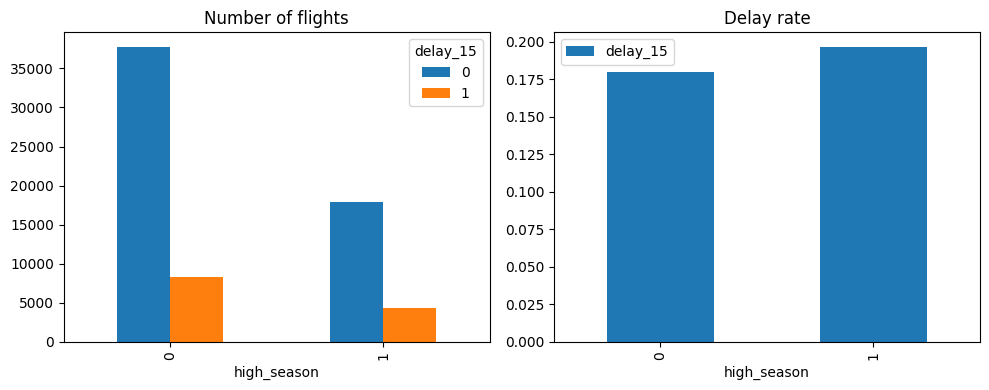

In [32]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].set_title("Number of flights")
ax[1].set_title("Delay rate")
pd.crosstab(data['high_season'],data['delay_15']).plot(kind="bar", ax=ax[0])
data[['high_season', 'delay_15']].groupby(['high_season']).mean().plot(kind="bar", ax=ax[1])
plt.tight_layout()
plt.show()

What is the behavior of the delay rate across season?

> Whether there is high season or not, delay rate is approximately similar. So, high season feature might not contribute to determine that flight can be delayed or not. 

---
#### Delay rate across type of flight

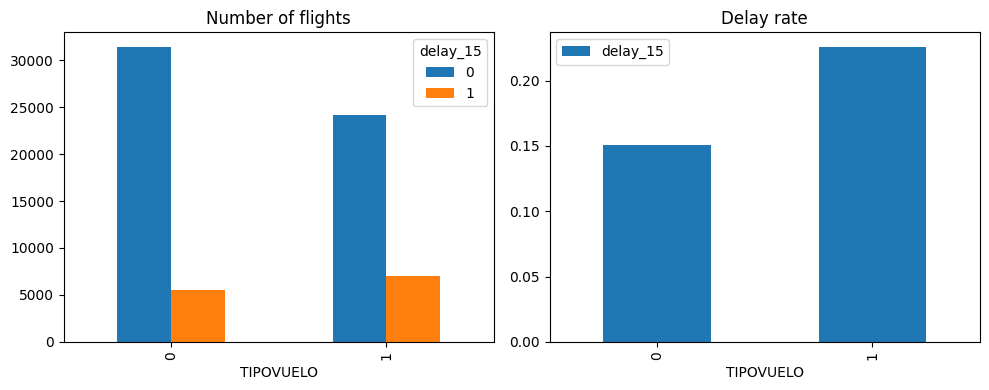

In [33]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].set_title("Number of flights")
ax[1].set_title("Delay rate")
pd.crosstab(data['TIPOVUELO'],data['delay_15']).plot(kind="bar", ax=ax[0])
data[['TIPOVUELO', 'delay_15']].groupby(['TIPOVUELO']).mean().plot(kind="bar", ax=ax[1])
plt.tight_layout()
plt.show()

What is the behavior of the delay rate across type of flight?

> International flights have comparitively high delayrate than national flights. Number of international flights are less but still its delay rate is high. So, type of flight will contribute to determine that flight can be delayed or not. 

---
#### Delay rate across destination difference

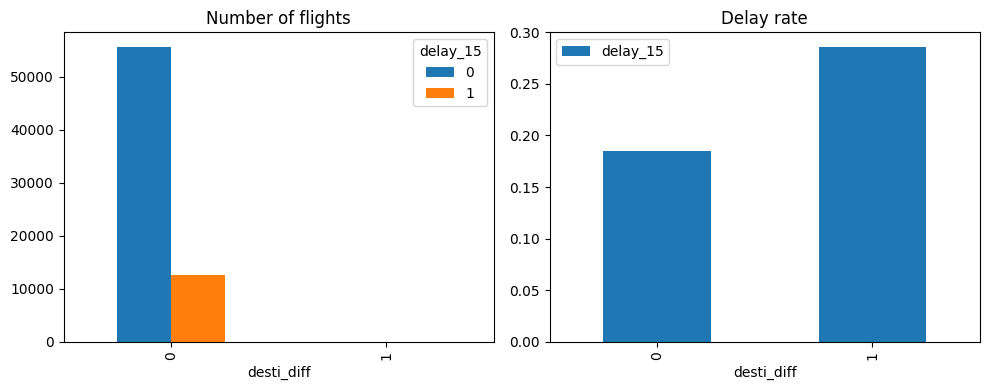

In [34]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].set_title("Number of flights")
ax[1].set_title("Delay rate")
pd.crosstab(data['desti_diff'],data['delay_15']).plot(kind="bar", ax=ax[0])
data[['desti_diff', 'delay_15']].groupby(['desti_diff']).mean().plot(kind="bar", ax=ax[1])
plt.tight_layout()
plt.show()

What is the behavior of the delay rate across destination difference?

> Number of flights whose destination planned is different from destination operated, means (Des-I and Des-O are different) are less, but its delay rate is high. So, destination difference feature will contribute to determine that flight will be delayed or not.  

---
#### Compare Emp-I, Emp-O, and OPERA contains almost same data

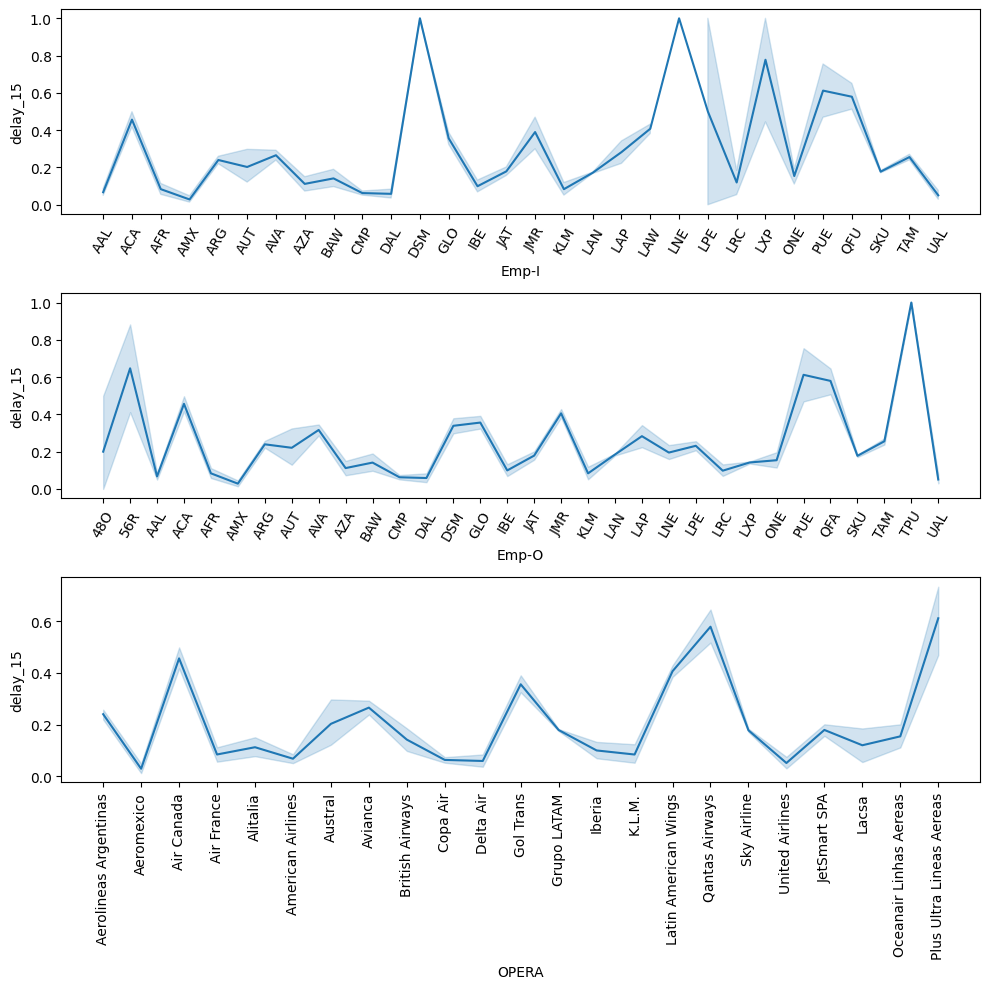

In [35]:
fig,ax = plt.subplots(3,1,figsize=(10,10))
ax[0].tick_params(axis='x', rotation=60)
ax[1].tick_params(axis='x', rotation=60)
ax[2].tick_params(axis='x', rotation=90)
sb.lineplot(data=data,x="Emp-I", y="delay_15", estimator="mean", ax=ax[0])
sb.lineplot(data=data,x="Emp-O", y="delay_15", estimator="mean", ax=ax[1])
sb.lineplot(data=data,x="OPERA", y="delay_15", estimator="mean", ax=ax[2])
plt.tight_layout()
plt.show()

In [36]:
data[['period_day','delay_15']].groupby("period_day").mean()

,delay_15
period_day,
afternoon,0.199404
morning,0.160066
night,0.200023


- In Emp-I: **LXP** has 77% delay rate, **PUE** has 61% delay rate.
- In Emp-O: **56R** has 64% delay rate, we can observe that 56R flight is never scheduled means not in Emp-I, but when 56R is operated flight its delay rate is high, same goes with TPU in Emp-O. 
- In OPERA, **Plus Ultra Lineas Aereas**, **Qantas Airways**, and **Air Canada** have high delay rate. 
- Apparently, **Groupo LATAM** and **Sky Airline** has low delay rate, even though maximum number of flights operated are of these airlines. 

**What variables would you expect to have the most influence in predicting delays?**
> SIGLADES, OPERA, MES, TIPOVUELO, and desti_diff will have most influence in predicting delays.

> **If min_diff feature is included in training then I will gain 100% accuracy and no loss, because my ground truth feature is delay_15 feature which is generated from min_diff. So will not include min_diff feature while training to predict delay_15, to check that whether other features can predict the delay or not.**

> Considered: Output label as delay_15 feature. 

### Corelation

In [38]:
print(data.corr(numeric_only=True))

                Vlo-I     Vlo-O       DIA       MES       AÑO  TIPOVUELO  \
Vlo-I        1.000000  0.997833 -0.001963  0.015574 -0.000955   0.404107   
Vlo-O        0.997833  1.000000 -0.001965  0.017054 -0.000950   0.403343   
DIA         -0.001963 -0.001965  1.000000  0.014318 -0.009073  -0.001277   
MES          0.015574  0.017054  0.014318  1.000000 -0.008642  -0.011564   
AÑO         -0.000955 -0.000950 -0.009073 -0.008642  1.000000   0.005891   
TIPOVUELO    0.404107  0.403343 -0.001277 -0.011564  0.005891   1.000000   
high_season  0.013955  0.013136  0.183613 -0.293902  0.007793  -0.001707   
min_diff     0.058629  0.058296 -0.006706  0.077280  0.002913   0.072733   
delay_15     0.067773  0.066954 -0.002517  0.083416  0.004394   0.096295   
desti_diff   0.013409  0.007467 -0.005605 -0.001321 -0.000110   0.001707   
flight_diff -0.092759 -0.092038 -0.004079 -0.007355 -0.003324  -0.328404   

             high_season  min_diff  delay_15  desti_diff  flight_diff  
Vlo-I          

<a id="question4"></a>
### Q 4: Regression model for predicting likelihood of flight delay


Des-O and SIGLADES provides same data, one provide city code and other provides city name. There is only one exception where city name is Buenos Aires, Des-O values are SABE and SAEZ which are two airports of same city. So only including SIGLADES feature in input feature.

In [39]:
# Input features
cols = ['Vlo-I', 'Des-I', 'Emp-I', 'Vlo-O', 'Emp-O', 'DIA', 'MES', 'DIANOM', 'TIPOVUELO', 'OPERA','SIGLADES', 'high_season', 'period_day', 'desti_diff', 'flight_diff']
input_data = data[cols]

#### One-Hot Encoding

- As majority of data contains categorical features, tree and ensemble algorithms will perform well. The categorical data needs to be converted into numerical data. 
- If I assign numbers to categories, decision tree algorithm will treat them as ordinal values. So, categorical data should be converted to one-hot encoding. 

In [40]:
new_data = pd.get_dummies(input_data)
# 229 columns after one-hot encoding

#### Split dataset

- Training dataset: 80% 
- Test dataset: 20%

I have used 10-fold cross validation approach. So, it will generate validation sets while training the model.  

In [41]:
# Split dataset
X = new_data
y = data['delay_15']
print("Original:",X.shape, y.shape)
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=0.2, random_state=9)
print("Train data:",train_X.shape, train_y.shape)
print("Test data:",test_X.shape, test_y.shape)

Original: (68206, 229) (68206,)
Train data: (54564, 229) (54564,)
Test data: (13642, 229) (13642,)


### Regression Model : To estimate likelihood of flight delay

In [42]:
class Regression_model:
    def __init__(self, train_X, train_y, test_X, test_y):
        self.train_X = train_X
        self.train_y = train_y
        self.test_X = test_X
        self.test_y = test_y
                
    def train(self,estimator, grid):
        model = GridSearchCV(estimator, grid)
        model.fit(self.train_X, self.train_y)
        print("Best parameters:",model.best_params_)
        return model
        
    def results(self, model):
        prob = model.predict(self.test_X)
        class_lbl = np.array(prob)
        class_lbl[prob>=0.5] = 1
        class_lbl[prob<0.5] = 0
        print('Mean Squared Error:',mean_squared_error(self.test_y, prob))
        print('Accuracy:', accuracy_score(self.test_y, class_lbl))
        return prob, class_lbl 

### Decision Tree Regressor

In [43]:
decision = Regression_model(train_X, train_y, test_X, test_y)
dmodel = decision.train(DecisionTreeRegressor(random_state=9), {'max_depth':[2,3,5,10,20,None]})
dprob, dclass_lbl = decision.results(dmodel)

Best parameters: {'max_depth': 10}
Mean Squared Error: 0.1398385168737967
Accuracy: 0.820554170942677


### Random Forest Regressor

In [44]:
ran = Regression_model(train_X, train_y, test_X, test_y)
rmodel = ran.train(RandomForestRegressor(random_state=9),{'n_estimators':[5,10,50,100],'max_depth':[3,5,10]})
rprob, rclass_lbl = ran.results(rmodel)

Best parameters: {'max_depth': 10, 'n_estimators': 100}
Mean Squared Error: 0.13218547788240417
Accuracy: 0.8267849288960563


### XGBoost Regressor

In [41]:
xgb = Regression_model(train_X, train_y, test_X, test_y)
xmodel = xgb.train(XGBRegressor(random_state=9),{'n_estimators':[5,10,50,100],'max_depth':[3,5,10]})
xprob, xclass_lbl = xgb.results(xmodel)

Best parameters: {'max_depth': 5, 'n_estimators': 100}
Mean Squared Error: 0.1295206219239433
Accuracy: 0.829277232077408


XG Boost Algorithm is go to algorithm for categorical data. 

### Loss across various ensemble algorithm

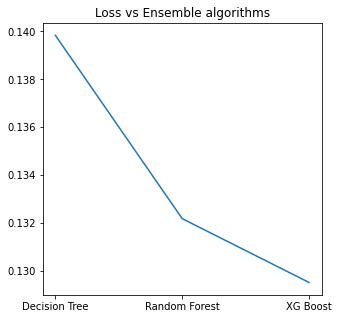

In [42]:
loss=[]
loss.append(mean_squared_error(test_y,dprob))
loss.append(mean_squared_error(test_y,rprob))
loss.append(mean_squared_error(test_y,xprob))


fig,ax = plt.subplots(figsize=(5,5))
ax.set_title("Loss vs Ensemble algorithms")
x_lbl = ['Decision Tree', 'Random Forest', 'XG Boost']
sb.lineplot(x=x_lbl, y=loss)
plt.show()

#### Results of likelihood

- XGBoost Regressor performs well, and I have used minimum squared error as loss function to measure the likelihood probability of the flight getting delayed. 

<a id="question5"></a>
### Q 5: Predictive task

In [43]:
class Predictive_model(Regression_model):
    def __init__(self, train_X, train_y, test_X, test_y):
        super().__init__(train_X, train_y, test_X, test_y)
        
    def predictive_results(self, model):
        lbl = model.predict(self.test_X)
        print('Accuracy:', accuracy_score(self.test_y, lbl))
        return lbl 

### Decision Tree Classifier

In [44]:
pdecision = Predictive_model(train_X, train_y, test_X, test_y)
pdmodel = pdecision.train(DecisionTreeClassifier(random_state=9), {'max_depth':[2,3,5,10,20,None]})
pdlbl = pdecision.predictive_results(pdmodel)

Best parameters: {'max_depth': 10}
Accuracy: 0.8215071103943703


### Random Forest Classifier

In [45]:
pran = Predictive_model(train_X, train_y, test_X, test_y)
prmodel = pran.train(RandomForestClassifier(random_state=9),{'n_estimators':[5,10,50,100],'max_depth':[3,5,10]})
prlbl = pran.predictive_results(prmodel)

Best parameters: {'max_depth': 10, 'n_estimators': 100}
Accuracy: 0.8224600498460636


### XGBoost Classifier

In [46]:
pxgb = Predictive_model(train_X, train_y, test_X, test_y)
pxmodel = pxgb.train(XGBClassifier(random_state=9),{'n_estimators':[5,10,50,100],'max_depth':[3,5,10]})
pxlbl = pxgb.predictive_results(pxmodel)

Best parameters: {'max_depth': 5, 'n_estimators': 100}
Accuracy: 0.8281043835214777


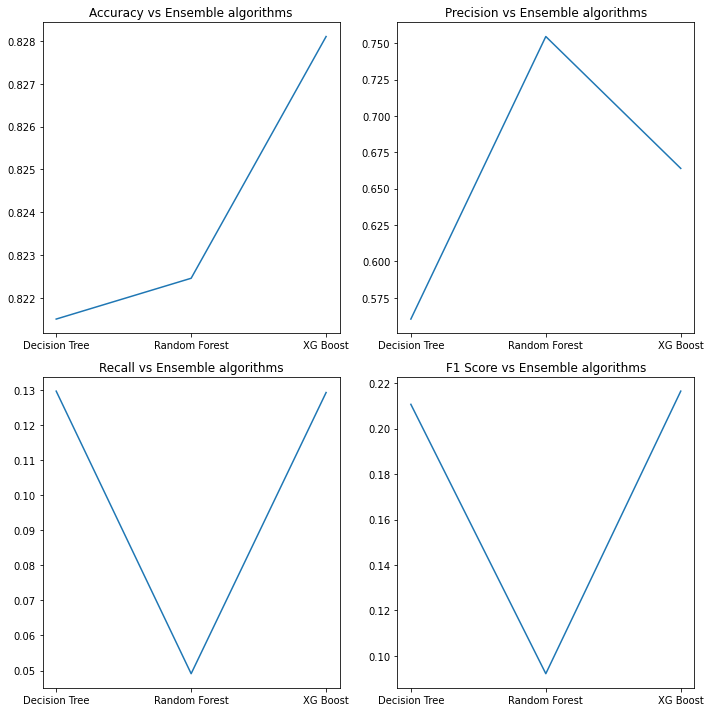

In [47]:
acc = []
acc.append(accuracy_score(test_y,pdlbl))
acc.append(accuracy_score(test_y,prlbl))
acc.append(accuracy_score(test_y,pxlbl))

pre = []
pre.append(metrics.precision_score(test_y,pdlbl))
pre.append(metrics.precision_score(test_y,prlbl))
pre.append(metrics.precision_score(test_y,pxlbl))

rec = []
rec.append(metrics.recall_score(test_y,pdlbl))
rec.append(metrics.recall_score(test_y,prlbl))
rec.append(metrics.recall_score(test_y,pxlbl))

f1 = []
f1.append(metrics.f1_score(test_y,pdlbl))
f1.append(metrics.f1_score(test_y,prlbl))
f1.append(metrics.f1_score(test_y,pxlbl))


fig,ax = plt.subplots(2,2,figsize=(10,10))
ax[0][0].set_title("Accuracy vs Ensemble algorithms")
ax[0][1].set_title("Precision vs Ensemble algorithms")
ax[1][0].set_title("Recall vs Ensemble algorithms")
ax[1][1].set_title("F1 Score vs Ensemble algorithms")
x_lbl = ['Decision Tree', 'Random Forest', 'XG Boost']
sb.lineplot(x=x_lbl, y=acc, ax=ax[0][0])
sb.lineplot(x=x_lbl, y=pre, ax=ax[0][1])
sb.lineplot(x=x_lbl, y=rec, ax=ax[1][0])
sb.lineplot(x=x_lbl, y=f1, ax=ax[1][1])
plt.tight_layout()
plt.show()

The best performance is of XGBoost Classifier to predict that whether flight is delayed or not. Initially, used accuracy to measure the performance of model. 

### Classification Report

In [48]:
print("Decision Tree")
print(classification_report(test_y,pdlbl))
print("Random Forest")
print(classification_report(test_y,prlbl))
print("XG Boost")
print(classification_report(test_y,pxlbl))

Decision Tree
              precision    recall  f1-score   support

           0       0.83      0.98      0.90     11137
           1       0.56      0.13      0.21      2505

    accuracy                           0.82     13642
   macro avg       0.70      0.55      0.56     13642
weighted avg       0.78      0.82      0.77     13642

Random Forest
              precision    recall  f1-score   support

           0       0.82      1.00      0.90     11137
           1       0.75      0.05      0.09      2505

    accuracy                           0.82     13642
   macro avg       0.79      0.52      0.50     13642
weighted avg       0.81      0.82      0.75     13642

XG Boost
              precision    recall  f1-score   support

           0       0.83      0.99      0.90     11137
           1       0.66      0.13      0.22      2505

    accuracy                           0.83     13642
   macro avg       0.75      0.56      0.56     13642
weighted avg       0.80      0.83    

### Confusion Matrix

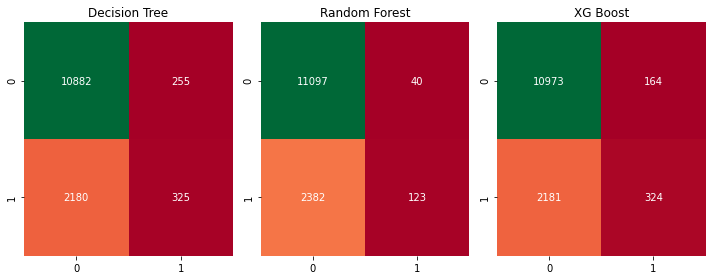

In [49]:
cf1 = confusion_matrix(test_y,pdlbl)
cf2 = confusion_matrix(test_y,prlbl)
cf3 = confusion_matrix(test_y,pxlbl)
fig, ax= plt.subplots(1,3, figsize=(10,4))

ax[0].set_title("Decision Tree")
ax[1].set_title("Random Forest")
ax[2].set_title("XG Boost")
sb.heatmap(cf1,annot=True,fmt='',cmap ='RdYlGn', cbar=False, ax=ax[0])
sb.heatmap(cf2,annot=True,fmt='',cmap ='RdYlGn', cbar=False, ax=ax[1])
sb.heatmap(cf3,annot=True,fmt='',cmap ='RdYlGn', cbar=False, ax=ax[2])
plt.tight_layout()
plt.show()

#### Confusion matrix

- **True Negative** (TN - 00) : The flights have actually not delayed, and model predicts not delayed.
- **False Positive** (FP - 01) : Flights have actually not delayed, but model predicts the flight delay.
- **False Negative** (FN - 10) : Flights have delayed, but model predicts that flights are not delayed.
- **True Positive** (TP - 11) : Flights have delays, and model predicts the flights are delayed.

### Observations
- All the models predicts True negatives correctly, because we have received more data of flights getting not delays. So data was biased towards flights getting not delayed. 
- Random Forest predicts minimum FP which are 40, compared to Decision tree and XGBoost classifiers.
- The best algorithm can be picked based upon requirements, if client wants less False Positive then Random Forest classifer is best option. If client wants less False Negatives then XGBoost is goof solution.  
- According to me, F1 score metrics is best way to balance, we want less FP, less FN and more TP. XGBoost performs slighly better than decision tree, but consumes more time in training.
- If time is the requirement constraint to train model, then decision tree is faster and provides almost same f1 score as XGBoost classifier.

### Analyze decision tree Split rules

In [50]:
features = list(new_data.columns)
r = tree.export_text(pdmodel.best_estimator_, feature_names=features, show_weights=True, max_depth=3)
print(r)

|--- TIPOVUELO <= 0.50
|   |--- MES <= 5.50
|   |   |--- period_day_night <= 0.50
|   |   |   |--- Vlo-O <= 837.00
|   |   |   |   |--- truncated branch of depth 7
|   |   |   |--- Vlo-O >  837.00
|   |   |   |   |--- truncated branch of depth 7
|   |   |--- period_day_night >  0.50
|   |   |   |--- high_season <= 0.50
|   |   |   |   |--- truncated branch of depth 7
|   |   |   |--- high_season >  0.50
|   |   |   |   |--- truncated branch of depth 7
|   |--- MES >  5.50
|   |   |--- period_day_morning <= 0.50
|   |   |   |--- DIA <= 26.50
|   |   |   |   |--- truncated branch of depth 7
|   |   |   |--- DIA >  26.50
|   |   |   |   |--- truncated branch of depth 7
|   |   |--- period_day_morning >  0.50
|   |   |   |--- OPERA_Latin American Wings <= 0.50
|   |   |   |   |--- truncated branch of depth 7
|   |   |   |--- OPERA_Latin American Wings >  0.50
|   |   |   |   |--- truncated branch of depth 7
|--- TIPOVUELO >  0.50
|   |--- OPERA_Latin American Wings <= 0.50
|   |   |--- SIG

> **TIPOVUELO, MES, OPERA_Latin American Wings, period_day, SIGLADES** and **Vlo-O** are most influential variables in predicting flights delay.

#### Future Improvement
---
- Evaluate the FN and FP data records and understand that on which kind of data record, model is not predicting correct answer.  
- Artificial Neural Network (ANN) with unbiased dataset can lead to more better model for predicting flight delays.